# Convolutional NN & Data management & Evaluation

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

https://pytorch.org/docs/stable/torchvision/transforms.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [0]:
import numpy as np
import torch
import torchvision 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from time import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # = scale from [0,1] to [-1,1]
                              ])

train_set = datasets.CIFAR10(root='CIFAR10_train', download=True, train=True, transform=transform)
val_set = datasets.CIFAR10('CIFAR10_val', download=True, train=False, transform=transform)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f'type(train_set): {type(train_set)}')

Files already downloaded and verified
Files already downloaded and verified
type(train_set): <class 'torchvision.datasets.cifar.CIFAR10'>


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images shape: torch.Size([4, 3, 32, 32])
labels shape: torch.Size([4])

 Sample images:


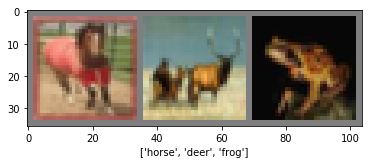

In [0]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

train_iter = iter(train_loader)
images, labels = train_iter.next()

print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

#
print('\n Sample images:')
def show_images(images):
    normal_imgs = (images/2 + 0.5).numpy()
    plt.imshow(np.transpose(normal_imgs, [1,2,0])) # test.shape = torch.Size([3, 32, 32])    

N_IMAGES = 3    
show_images(torchvision.utils.make_grid(images[:N_IMAGES]))
plt.xlabel([classes[elem] for elem in labels[:N_IMAGES]]);

# Build Convolutional NN

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)       # https://pytorch.org/docs/stable/nn.html#conv2d      
        self.pool = nn.MaxPool2d(2, 2)        # https://pytorch.org/docs/stable/nn.html#maxpool2d
        self.conv2 = nn.Conv2d(6, 16, 5)        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   
        self.fc2 = nn.Linear(120, 60)         # https://pytorch.org/docs/stable/nn.html#linear
        self.fc3 = nn.Linear(60, 10)            

    def forward(self, x):                       # sizes:
        x = self.pool(F.relu(self.conv1(x)))    # 3x32x32 --> 6x28x28 --> 6x14x14
        x = self.pool(F.relu(self.conv2(x)))    # 6x14x14 --> 16x10x10 --> 16x5x5
        x = x.view(-1, 16 * 5 * 5)              # join features --> 16x5x5 --> 400
        x = F.relu(self.fc1(x))                 # 400 --> 120
        x = F.relu(self.fc2(x))                 # 120 --> 60
        x = self.fc3(x)                         # 60 --> 10
        return x

In [0]:
def train_loop(cn):
  
    cn = cn.to(device)
    # restart mini batch
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

    
    ce_loss = nn.CrossEntropyLoss()
    lr = 1e-4
    optimiser = optim.Adam(cn.parameters(), lr=lr)

    ## run with mini-batch
    loss_curve = []
    running_loss = 0
    for epoch in range(10):
        for i, mini_batch in enumerate(train_loader, 0):
            images, labels = mini_batch
            images = images.to(device)
            labels = labels.to(device)            
            
            cn.zero_grad()

            predictions = cn(images)

            loss = ce_loss(predictions, labels)
            loss_curve.append(loss)
            loss.backward()

            optimiser.step()

            running_loss += loss.item()
                    
cn = ConvNet()
train_loop(cn)

# Simple Evaluation

## Random Images


Predictions:
['horse', 'horse', 'deer', 'truck']


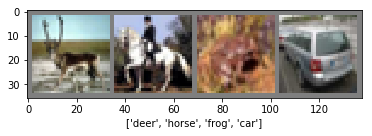

In [30]:
def test_random(cn):
    cn.cpu()
    cn.eval()
    test_iter = iter(val_loader)
    images, labels = test_iter.next()

    show_images(torchvision.utils.make_grid(images))
    plt.xlabel([classes[elem] for elem in labels]);

    print('\nPredictions:')

    predictions = cn(images)
    labels_int = torch.argmax(predictions, dim=1)
    predicted_labels = [classes[elem] for elem in labels_int]
    print(predicted_labels)
    
test_random(cn)

## Check Overall Performance and Best Performant Classes

https://pytorch.org/docs/stable/torch.html#locally-disabling-gradient-computation

In [31]:
def total_performance(cn):
    cn.cpu()
    cn.eval()
    total_images = 0
    total_correct_images = 0
    observed = []
    predicted = []
    with torch.no_grad():
        for data in val_loader:
            images, labels = data

            predictions = cn(images)
            labels_int = torch.argmax(predictions, dim=1)

            observed.extend(labels.numpy())
            predicted.extend(labels_int.numpy())

            total_images += labels.shape[0]
            total_correct_images += (labels == labels_int).sum().item()        

    acc = np.round((total_correct_images/total_images) * 100, 2)
    print(f'Overall Accuracy on Test Set: {acc}%')

    print('Performance per class:')
    comp = pd.DataFrame({'observed': observed, 'predicted': predicted})
    comp['flag_correct'] = comp['observed'] == comp['predicted']
    stats = comp.groupby('observed')['flag_correct'].mean()
    stats.index = [classes[elem] for elem in stats.index]
    print(stats)
    
total_performance(cn)    

Overall Accuracy on Test Set: 60.8%
Performance per class:
plane    0.669
car      0.726
bird     0.391
cat      0.368
deer     0.643
dog      0.486
frog     0.724
horse    0.637
ship     0.813
truck    0.623
Name: flag_correct, dtype: float64


# Train ConvNet II

In [0]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)          # https://pytorch.org/docs/stable/nn.html#conv2d 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv1_lr = nn.LeakyReLU()
        
        self.conv1_mp = nn.MaxPool2d(2, 2)        # https://pytorch.org/docs/stable/nn.html#maxpool2d
        
        self.conv2 = nn.Conv2d(32, 64, 5)         # https://pytorch.org/docs/stable/nn.html#conv2d 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv2_lr = nn.LeakyReLU()
        
        self.conv2_mp = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 800)
        self.fc1_do = nn.Dropout()
        self.fc2 = nn.Linear(800, 200)           # https://pytorch.org/docs/stable/nn.html#linear
        self.fc3 = nn.Linear(200, 10)            

    def forward(self, x):                        # sizes:
        x = self.conv1_lr(self.conv1_bn(self.conv1(x)))                   # 3x32x32 --> 32x28x28
        x = self.conv1_mp(x)                                              # 32x28x28 --> 32x14x14
        x = self.conv2_lr(self.conv2_bn(self.conv2(x)))                   # 32x14x14 --> 64x10x10 
        x = self.conv2_mp(x)                                              # 64x10x10 --> 64x5x5
        x = x.view(-1, 64 * 5 * 5)              # join features --> 64x5x5 --> 1600
        x = self.fc1_do(F.relu(self.fc1(x)))    # 1600 --> 800
        x = F.relu(self.fc2(x))                 # 800 --> 200
        x = self.fc3(x)                         # 200 --> 10
        return x


Predictions:
['bird', 'cat', 'truck', 'car']
Overall Accuracy on Test Set: 74.61%
Performance per class:
plane    0.873
car      0.809
bird     0.603
cat      0.539
deer     0.782
dog      0.604
frog     0.851
horse    0.776
ship     0.802
truck    0.822
Name: flag_correct, dtype: float64
CPU times: user 7min 56s, sys: 14.5 s, total: 8min 11s
Wall time: 8min 14s


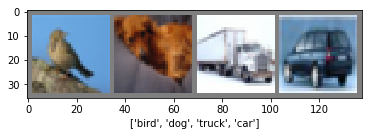

In [35]:
%%time

cn2 = ConvNet2()
train_loop(cn2)
test_random(cn2)
total_performance(cn2)  

# Playground

## Just to check whether it works - Prep for section "Train ConvNet"

https://www.quora.com/How-can-I-calculate-the-size-of-output-of-convolutional-layer

Given: 

* image of size *W* x *H*  
* convolution filter of size $F_{w}$ x $F_{h}$  
* padding of size *P*  
* stride of size $S_{w}$ x $S_{h}$  
  
The output image dimensions are going to be:  
  
$$W_{conv} = \frac{W - F_{w} + 2P}{S_{w}} + 1$$  
  
$$H_{conv} = \frac{W - F_{h} + 2P}{S_{h}} + 1$$   